In [1]:
# Initialize Otter

# Lab 9: Time Series

## Introduction
In this notebook, we will take a look at time series and their applications in economics.

**Learning Objectives:**

By the end of this lab, you should: 
* Feel comfortable with the concept of time series and why they are important
* Manipulate time series data with `pandas`
* Visualize time series data with `matplotlib`
* Model and forecast time series using the `darts` package

We'll start by loading in the necessary packages. Run the following cell to import our standard packages.

In [48]:
# Just run this cell
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline
plt.rcParams["figure.figsize"] = (10,3)

#! pip install darts --q

import darts
from darts import TimeSeries
from darts.dataprocessing.transformers.scaler import Scaler
from darts.models.forecasting.nhits import NHiTSModel
from darts.datasets import MonthlyMilkDataset
from darts.models.forecasting.auto_arima import AutoARIMA

## Section 1: Intro to Time Series

*What are time series?* Time series are a series of data points that are indexed by time. This means that data points are ordered by a time (can be hourly, daily, yearly, etc.) in a continuous, increasing order.

Examples of time series include:
* Daily temperature
* Heart rate
* Gross Domestic Product (GDP)

All of these examples have continuous and increasing time and provide important information about their respective data. In fact, many economic concepts such as inflation, exchange rates, and unemployment rate are all time series!

***

*Why are time series important?* Time series analysis allows economists and data scientists to understand possible underlying causes of trends and recognize patterns over time. This allows comparisons across time to be made and forecasts to be predicted. 

For example:
* Looking at trends and patterns in daily temperature could help cities prepare for extreme weather events.
* Analyzing heart rate could inform doctors of a possible cause of high or low heart rate.
* Predicting GDP a quarter before the official release could allow businesses to better plan production and capacity.
***

Let's take a look at a time series. In this lab, we will be working with Zillow's Zillow Obsered Rent Index or [ZORI](https://www.zillow.com/research/data/). From the Zillow website:
> **Zillow Observed Rent Index (ZORI):** A smoothed measure of the typical observed market rate rent across a given region. ZORI is a repeat-rent index that is weighted to the rental housing stock to ensure representativeness across the entire market, not just those homes currently listed for-rent. The index is dollar-denominated by computing the mean of listed rents that fall into the 40th to 60th percentile range for all homes and apartments in a given region, which is once again weighted to reflect the rental housing stock.

For more details about how ZORI is calculating and Zillow's methodology, click [here](https://www.zillow.com/research/methodology-zori-repeat-rent-27092/).

In summary, the ZORI index contains information about rental prices over time.

Let's take a look at the ZORI index by first loading the data using `pd.read_csv` method.

In [4]:
zori = pd.read_csv("zori1.csv")

Run the following cell to display information about the ZORI index.

In [6]:
zori

,RegionID,SizeRank,RegionName,RegionType,StateName,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,...,2021-12-31,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30
0,102001,0,United States,country,NaN,1370.301806,1381.971304,1392.389090,1403.203509,1408.901384,...,1928.945108,1937.304351,1955.272060,1971.256988,1997.731260,2019.752839,2044.662959,2065.275748,2078.546078,2084.084210
1,394913,1,"New York, NY",msa,NY,2506.196326,2533.311441,2552.989317,2570.501028,2573.663435,...,2957.725252,2984.899451,3032.151836,3082.959790,3142.381057,3201.035347,3258.611614,3308.938574,3327.647323,3321.271717
2,753899,2,"Los Angeles, CA",msa,CA,1977.874325,1990.644815,2004.443160,2016.922137,2031.255505,...,2808.206899,2825.516662,2850.339483,2881.506596,2919.113666,2953.089197,2978.850604,2999.777869,3013.211794,3019.026316
3,394463,3,"Chicago, IL",msa,IL,1478.149264,1490.961012,1502.702134,1528.952557,1535.997197,...,1795.629571,1808.471849,1823.778075,1843.010280,1865.307537,1890.513951,1911.437953,1930.811578,1939.370439,1941.933786
4,394514,4,"Dallas, TX",msa,TX,1180.713035,1191.112125,1202.397600,1209.409429,1216.117716,...,1724.699775,1736.260930,1747.886285,1758.449166,1780.575633,1807.486899,1842.009269,1866.378789,1876.715983,1875.844643
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
574,394322,861,"Altus, OK",msa,OK,404.816596,NaN,417.170690,NaN,NaN,...,NaN,NaN,NaN,735.821384,732.921061,771.810020,755.232683,810.606473,750.000000,821.649685
575,394687,869,"Hood River, OR",msa,OR,NaN,NaN,NaN,708.148593,NaN,...,NaN,2039.794902,NaN,2061.477514,2053.911628,2293.863629,2446.688466,2573.551207,2575.000000,2617.167354
576,394718,892,"Jamestown, ND",msa,ND,NaN,NaN,NaN,NaN,NaN,...,643.033893,632.188630,NaN,668.388884,715.417127,687.157390,702.818101,729.449277,771.000000,795.646586
577,394330,906,"Andrews, TX",msa,TX,NaN,NaN,480.844237,470.002683,NaN,...,NaN,901.423609,NaN,NaN,NaN,NaN,NaN,NaN,962.000000,1019.826674


**Question 1.1:** What information is stored in the ZORI data? What does each row represent?

*Type your answer here, replacing this text.*

Let's see if we can manipulate the data into a format that makes it easy to plot and model.

## Section 2: Time Series EDA

As you saw above, the ZORI index has information at the city level as well as an aggregate value for the entire United States. In this notebook, we'll be focusing on the aggregated US series. Let's select it here.

In [8]:
zUS = zori.iloc[0, :-1]
zUS

RegionID             102001
SizeRank                  0
RegionName    United States
RegionType          country
StateName               NaN
                  ...      
2022-04-30       1997.73126
2022-05-31      2019.752839
2022-06-30      2044.662959
2022-07-31      2065.275748
2022-08-31      2078.546078
Name: 0, Length: 95, dtype: object

We notice that the dates in the timeseries actually start from the 6th entry in the index. If we wanted to create a DataFrame, we would need to find a way to extract this information, in addition to the data stored in the ZORI column.

In [9]:
zori_dates = zUS[5:].index
zori_data = zUS[5:].to_list()

We now construct a DataFrame using this information.

In [26]:
zillow = pd.DataFrame(data={"DATE": zori_dates, "ZORI" : zori_data})
zillow["DATE"]=pd.to_datetime(zillow["DATE"].values.astype('datetime64[M]'))
zillow

,DATE,ZORI
0,2015-03-01,1370.301806
1,2015-04-01,1381.971304
2,2015-05-01,1392.389090
3,2015-06-01,1403.203509
4,2015-07-01,1408.901384
...,...,...
85,2022-04-01,1997.731260
86,2022-05-01,2019.752839
87,2022-06-01,2044.662959
88,2022-07-01,2065.275748


We might wonder what this looks like. Let's graph this time series.

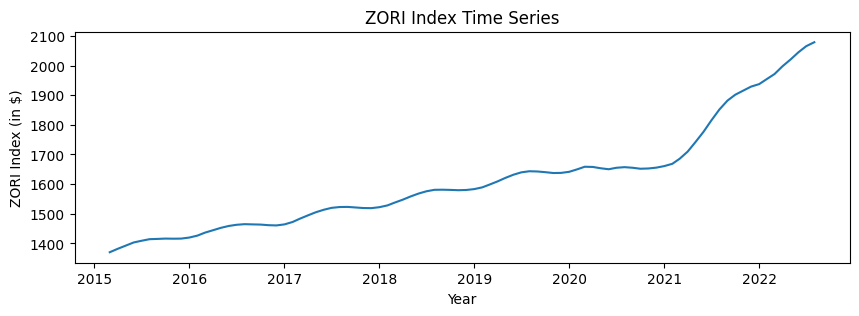

In [28]:
plt.plot(zillow["DATE"],zillow["ZORI"])
plt.xlabel("Year")
plt.ylabel("ZORI Index (in $)")
plt.title("ZORI Index Time Series");

**Question 2.1:** Do you notice anything interesting about this graph? In 2 to 3 sentences, describe any patterns you see, trends over time, or sudden differences.

*Type your answer here, replacing this text.*

## Section 3: United States Consumer Price Index

In this section, we'll explore the United States Consumer Price Index. From the Bureau of Labor Statistics:
> The Consumer Price Index (CPI) is a measure of the average change over time in the prices paid by urban consumers for a market basket of consumer goods and services. Indexes are available for the U.S. and various geographic areas. Average price data for select utility, automotive fuel, and food items are also available.

Notably, rent prices are also included in the CPI calculation. 

We've downloaded historical US CPI data for you from the [Federal Reserve Economic Data (FRED) website](https://fred.stlouisfed.org/series/CUUR0000SEHA). Since our ZORI data starts on 03/31/2015, we've adjusted the sliders on the FRED website to only extract starting from 03/31/2015. We've also renamed the columns to be more readable.

In [34]:
zillow = zillow.reset_index()
usCPI = pd.read_csv("usCPI.csv")
usCPI = usCPI.rename(columns={"CUUR0000SEHA": "CPI"})
usCPI = usCPI.iloc[1:, :]
usCPI = usCPI.reset_index()
usCPI = usCPI.drop("index",axis=1)

In [36]:
usCPI.head()

,DATE,CPI
0,2015-04-01,283.598
1,2015-05-01,284.245
2,2015-06-01,285.031
3,2015-07-01,286.090
4,2015-08-01,287.068


We can try plotting this to see what it looks like.

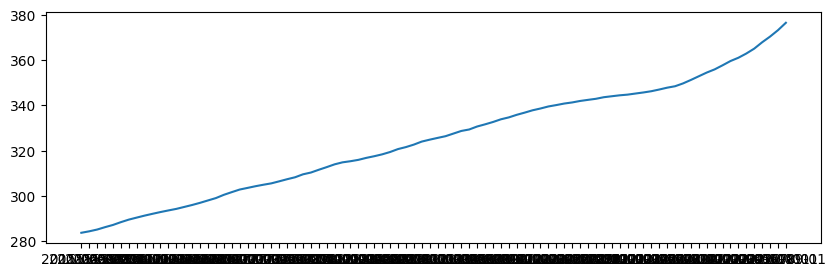

In [40]:
plt.plot(usCPI["DATE"], usCPI["CPI"]);

Whoops! Looks like there is something wrong with the x-axis. Let's take a look at the data types of the `usCPI` dataframe using the `dtypes` method. This method displays the data types for each of the columns in the data frame.

In [41]:
usCPI.dtypes

DATE     object
CPI     float64
dtype: object

Looks like the `DATE` column has an `object` data type. Let's see if we can adjust this to be something that works better with time series. We can use the `pd.to_datetime()` method to convert to a date time format. This will allow Python and `pandas` to know to treat these values as dates and not just strings or other text.

In [42]:
usCPI["DATE"]=pd.to_datetime(usCPI["DATE"])

In [43]:
usCPI.head()

,DATE,CPI
0,2015-04-01,283.598
1,2015-05-01,284.245
2,2015-06-01,285.031
3,2015-07-01,286.090
4,2015-08-01,287.068


While the data does not look much different, the data types have changed.

In [45]:
usCPI.dtypes

DATE    datetime64[ns]
CPI            float64
dtype: object

**Question 3.1:** Create a line plot using the `usCPI` dataframe with `DATE` on the x-axis and `CPI` on the y-axis. Label you axes accordingly and give the plot an appropriate title.

Hint: Look at how we plotted the ZORI index in the previous section if you need a refresher.

In [ ]:
# Your code here

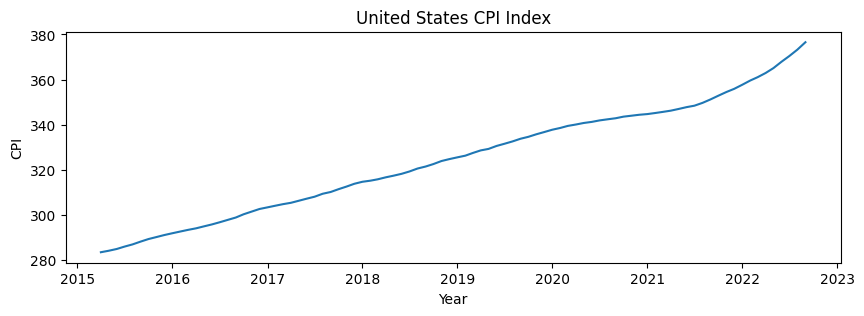

In [46]:
# Delete me
plt.plot(usCPI["DATE"], usCPI["CPI"])
plt.xlabel("Year")
plt.ylabel("CPI")
plt.title("United States CPI Index");

## Section 4: Forecasting CPI

In this section, we will learn how to model and forecast time series, including CPI. To do this, we'll be using a package called `darts`. `darts` uses a similar `fit()` and `predict()` workflow as `scikit-learn` and allows for powerful time series models to be build with just a few lines of code.

To learn more about `darts`, let's do an example using an Autoregressive integrated moving average model or ARIMA. An ARIMA model uses a moving average of past time series values to predict future values.  

In this example, we'll be attempting to forecast the number of pounds of milk produced by cows. We'll start by loading in the data.

In [49]:
series_milk = MonthlyMilkDataset().load()

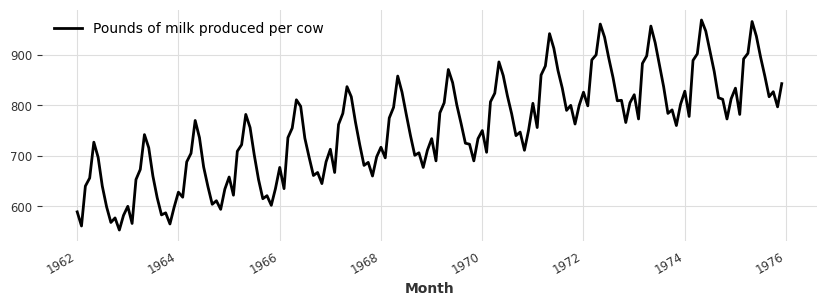

In [51]:
series_milk.plot(label="Pounds of milk produced per cow")
plt.legend();

Now that we have an idea of what our time series looks like, let's split our data into test and control datasets. This is important so we can test and evaluate our model on data that the model did not encounter in training. This allows us to see if our model is generalizable and applicable to real world data.

In [54]:
train_milk, test_milk = series_milk[:-36], series_milk[-36:]

Now that we have out train and test data, let's work on developing our model. Similar to `scikit-learn` models, `darts` follows a similar workflow:

 1. Create your model
 2. Fit your model
 3. Predict using your model
 
Let's start by creating our ARIMA model.

In [66]:
arima_milk = AutoARIMA()

We now have our ARIMA model. In order to use our model to predict, we must first fit the model to the training data. We can do that using the `fit` method; passing in our training data as a parameter.

In [67]:
arima_milk.fit(train_milk)

Our model is now fitted and ready to predict. Let's predict the length of our test data so we can see how well the model did. We can do that by calling the `predict` method on the model with the number of time periods to predict as a parameter.


In [58]:
pred = arima_milk.predict(36)

Let's see how well our model did by visualizing our predictions against our test data.

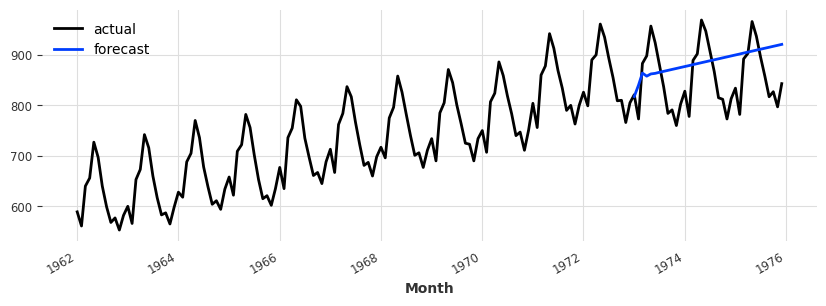

In [59]:
series_milk.plot(label="actual")
pred.plot(label="forecast")
plt.legend()
#print("MAPE = {:.2f}%".format(mape(series_air_scaled, pred)))

In [290]:
usCPI = usCPI[["DATE", "CPI"]]

In [291]:
usCPI

,DATE,CPI
0,2015-04-01,283.598
1,2015-05-01,284.245
2,2015-06-01,285.031
3,2015-07-01,286.090
4,2015-08-01,287.068
...,...,...
85,2022-05-01,365.116
86,2022-06-01,367.927
87,2022-07-01,370.448
88,2022-08-01,373.283


In [292]:
usCPI["DATE"] = pd.to_datetime(usCPI['DATE'])

C:\Users\am513\AppData\Local\Temp\ipykernel_25156\1247769527.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  usCPI["DATE"] = pd.to_datetime(usCPI['DATE'])


In [293]:
usCPI["DATE"]

0    2015-04-01
1    2015-05-01
2    2015-06-01
3    2015-07-01
4    2015-08-01
        ...    
85   2022-05-01
86   2022-06-01
87   2022-07-01
88   2022-08-01
89   2022-09-01
Name: DATE, Length: 90, dtype: datetime64[ns]

In [294]:
usCPI = usCPI.set_index("DATE")

In [295]:
usCPI

,CPI
DATE,
2015-04-01,283.598
2015-05-01,284.245
2015-06-01,285.031
2015-07-01,286.090
2015-08-01,287.068
...,...
2022-05-01,365.116
2022-06-01,367.927
2022-07-01,370.448


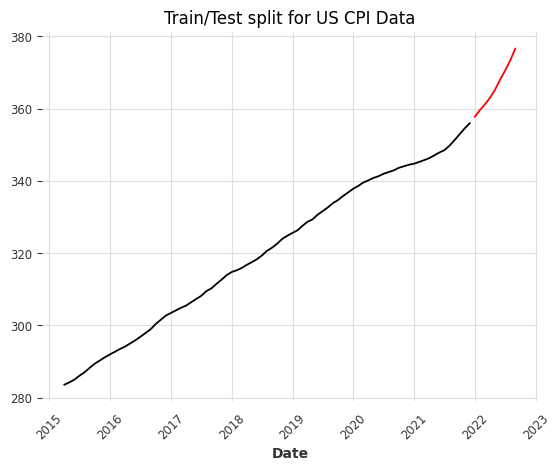

In [296]:
train = usCPI[usCPI.index < pd.to_datetime("2022-01-01", format='%Y-%m-%d')]
test = usCPI[usCPI.index >= pd.to_datetime("2022-01-01", format='%Y-%m-%d')]

plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.ylabel('')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Train/Test split for US CPI Data")
plt.show()

In [297]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [298]:
y = train['CPI']

In [299]:
ARMAmodel = SARIMAX(y, order = (1, 0, 1))

C:\Users\am513\anaconda3\envs\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\am513\anaconda3\envs\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [300]:
ARMAmodel = ARMAmodel.fit()

C:\Users\am513\anaconda3\envs\python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [301]:
y_pred = ARMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 

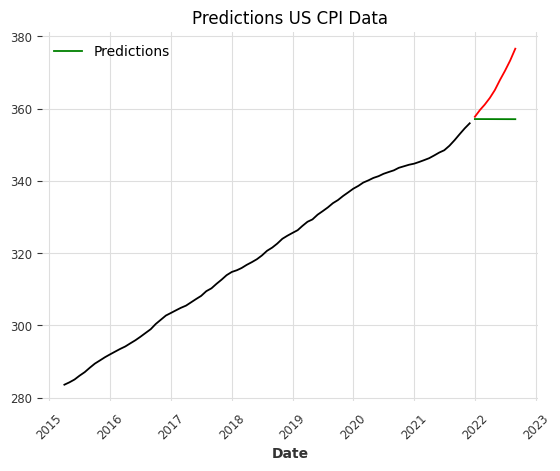

In [302]:

plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.plot(y_pred_out, color='green', label = 'Predictions')
plt.ylabel('')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.title("Predictions US CPI Data")
plt.legend()

In [304]:
import numpy as np
from sklearn.metrics import mean_squared_error

arma_rmse = np.sqrt(mean_squared_error(test["CPI"].values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

RMSE:  10.859972404354904


## Moving ARIMA

In [305]:
from statsmodels.tsa.arima.model import ARIMA

C:\Users\am513\anaconda3\envs\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\am513\anaconda3\envs\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\am513\anaconda3\envs\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\am513\anaconda3\envs\python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\am513\anaconda3\envs\python39\lib\site-packages\statsmodels\base\model.py:604: Conv

RMSE:  1.699626290777005


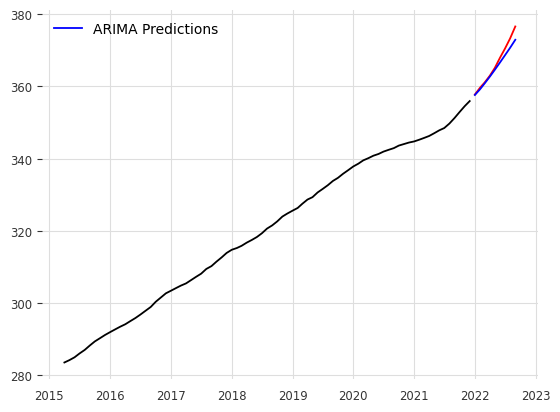

In [306]:
ARIMAmodel = ARIMA(y, order = (7, 4, 2))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = ARIMAmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.plot(y_pred_out, color='blue', label = 'ARIMA Predictions')
plt.legend()


import numpy as np
from sklearn.metrics import mean_squared_error

arma_rmse = np.sqrt(mean_squared_error(test["CPI"].values, y_pred_df["Predictions"]))
print("RMSE: ",arma_rmse)

Try playing with the parameters!

C:\Users\am513\anaconda3\envs\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\am513\anaconda3\envs\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\am513\anaconda3\envs\python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\am513\anaconda3\envs\python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\U

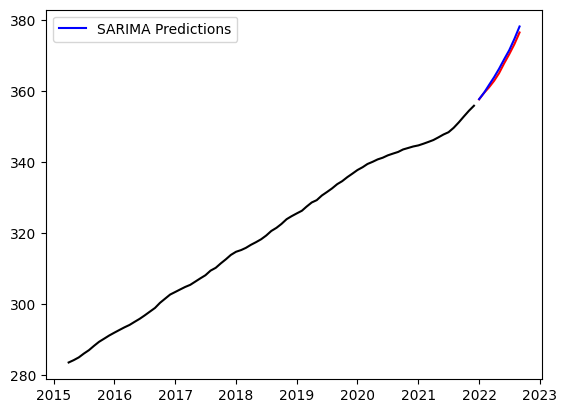

In [35]:
SARIMAXmodel = SARIMAX(y, order = (5, 4, 2), seasonal_order=(2,2,2,12))
SARIMAXmodel = SARIMAXmodel.fit()

y_pred = SARIMAXmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 
plt.plot(train, color = "black")
plt.plot(test, color = "red")
plt.plot(y_pred_out, color='Blue', label = 'SARIMA Predictions')
plt.legend()

## SARIMA Model

C:\Users\am513\anaconda3\envs\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\am513\anaconda3\envs\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\am513\anaconda3\envs\python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\am513\anaconda3\envs\python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\U

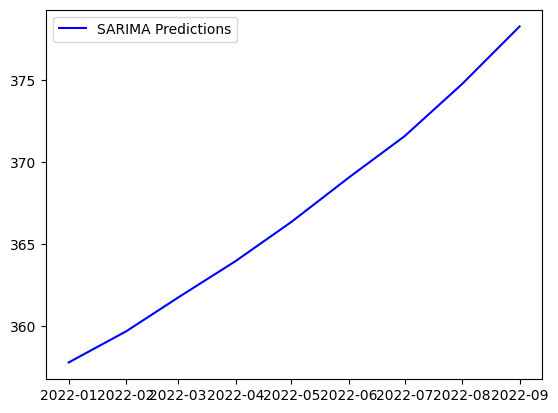

In [36]:
SARIMAXmodel = SARIMAX(y, order = (5, 4, 2), seasonal_order=(2,2,2,12))
SARIMAXmodel = SARIMAXmodel.fit()

y_pred = SARIMAXmodel.get_forecast(len(test.index))
y_pred_df = y_pred.conf_int(alpha = 0.05) 
y_pred_df["Predictions"] = SARIMAXmodel.predict(start = y_pred_df.index[0], end = y_pred_df.index[-1])
y_pred_df.index = test.index
y_pred_out = y_pred_df["Predictions"] 
plt.plot(y_pred_out, color='Blue', label = 'SARIMA Predictions')
plt.legend()

## Combining the Two Datasets

We want to combine both time series so that we can analyze them together. However, we notice that the `DATE` column has different values. ZORI is measured on the 31st of each month, while CPI is measured on the 1st day of each month. For our purposes, we can combine the two by using the `DATE` index from the US CPI and using the 1st day of the month.

In [311]:
usCPI.reset_index()["DATE"]

0    2015-04-01
1    2015-05-01
2    2015-06-01
3    2015-07-01
4    2015-08-01
        ...    
85   2022-05-01
86   2022-06-01
87   2022-07-01
88   2022-08-01
89   2022-09-01
Name: DATE, Length: 90, dtype: datetime64[ns]

In [314]:
combined = pd.DataFrame({"DATE": usCPI.reset_index()["DATE"], "CPI": usCPI.reset_index()["CPI"], "ZORI" : zillow["ZORI"]})
combined

,DATE,CPI,ZORI
0,2015-04-01,283.598,1370.301806
1,2015-05-01,284.245,1381.971304
2,2015-06-01,285.031,1392.389090
3,2015-07-01,286.090,1403.203509
4,2015-08-01,287.068,1408.901384
...,...,...,...
85,2022-05-01,365.116,1997.731260
86,2022-06-01,367.927,2019.752839
87,2022-07-01,370.448,2044.662959
88,2022-08-01,373.283,2065.275748


## Plotting

We can try plotting this graph to see if we can find anything interesting.

<AxesSubplot: xlabel='DATE', ylabel='CPI'>

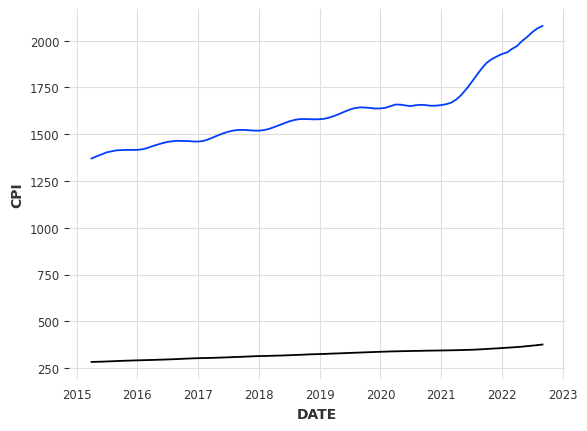

In [315]:
sns.lineplot(data=combined, x="DATE", y="CPI")
sns.lineplot(data=combined, x="DATE", y="ZORI")

We have a problem! ZORI and CPI use a different scale!

### Logging Our Data

We can try logging our data to make them easier to compare.

In [316]:
combined["log CPI"] = np.log(combined["CPI"])
combined["log ZORI"] = np.log(combined["ZORI"])

<AxesSubplot: xlabel='DATE', ylabel='log CPI'>

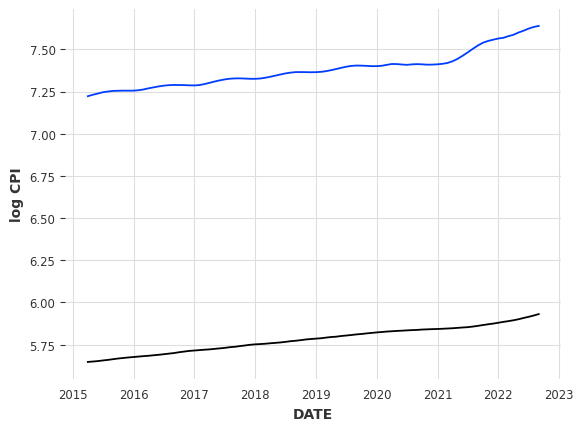

In [317]:
sns.lineplot(data=combined, x="DATE", y="log CPI")
sns.lineplot(data=combined, x="DATE", y="log ZORI")

Now, the similar shape becomes more apparent, but we can see that log ZORI is roughly in the 7 range, while log CPI is roughly in the 5 range. We can try subtracting 2 to log ZORI to see if they are similar.

In [318]:
combined["modified ZORI"] = combined["log ZORI"].apply(lambda x: x-1.6)

In [319]:
combined

,DATE,CPI,ZORI,log CPI,log ZORI,modified ZORI
0,2015-04-01,283.598,1370.301806,5.647558,7.222786,5.622786
1,2015-05-01,284.245,1381.971304,5.649837,7.231266,5.631266
2,2015-06-01,285.031,1392.389090,5.652598,7.238776,5.638776
3,2015-07-01,286.090,1403.203509,5.656306,7.246513,5.646513
4,2015-08-01,287.068,1408.901384,5.659719,7.250566,5.650566
...,...,...,...,...,...,...
85,2022-05-01,365.116,1997.731260,5.900215,7.599767,5.999767
86,2022-06-01,367.927,2019.752839,5.907885,7.610730,6.010730
87,2022-07-01,370.448,2044.662959,5.914713,7.622988,6.022988
88,2022-08-01,373.283,2065.275748,5.922337,7.633019,6.033019


<AxesSubplot: xlabel='DATE', ylabel='log CPI'>

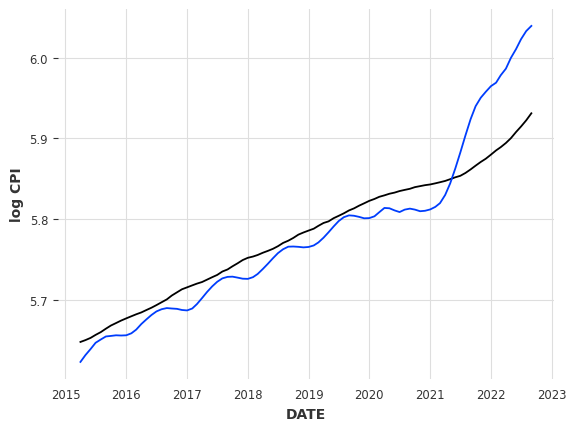

In [320]:
sns.lineplot(data=combined, x="DATE", y="log CPI")
sns.lineplot(data=combined, x="DATE", y="modified ZORI")

In [321]:
stats.pearsonr(combined["log CPI"], combined["log ZORI"])

PearsonRResult(statistic=0.954651447268295, pvalue=4.4054808381897e-48)

What are some things you notice in the graph?

We can see that ZORI has a lot more fluctuation than the CPI.

# VAR Models

We set the index as the date column.

In [322]:
df = combined.set_index("DATE")
df = df[["CPI", "ZORI"]]

In [323]:
df

,CPI,ZORI
DATE,,
2015-04-01,283.598,1370.301806
2015-05-01,284.245,1381.971304
2015-06-01,285.031,1392.389090
2015-07-01,286.090,1403.203509
2015-08-01,287.068,1408.901384
...,...,...
2022-05-01,365.116,1997.731260
2022-06-01,367.927,2019.752839
2022-07-01,370.448,2044.662959


We import some modules from the statsmodels library.

In [324]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

### Granger Causality

We first use Granger's Causality Tests to see the p-value of the correlations between different variables.

In [325]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [326]:
grangers_causation_matrix(df, variables = df.columns) 

,CPI_x,ZORI_x
CPI_y,1.0000,0.0
ZORI_y,0.0119,1.0


How can we interpret the findings above?

### Cointegration Test

We can use a cointegration test to see if the two time series are correlated before making any predictions.

In [327]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

In [328]:
cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
CPI    ::  20.2      > 12.3212   =>   True
ZORI   ::  5.2       > 4.1296    =>   True


### Splitting into Training and Testing Groups

In [329]:
nobs = 4
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)  # (4, 8)

(86, 2)
(4, 2)


## Transforming the Time Series to be Stationary

In order to perform our VAR test, we want our time series to be stationary. A stationary time series is one whose characteristics like mean and variance does not change over time.

In [330]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")  

In [331]:
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "CPI" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 1.0281
 No. Lags Chosen       = 2
 Critical value 1%     = -3.512
 Critical value 5%     = -2.897
 Critical value 10%    = -2.586
 => P-Value = 0.9946. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "ZORI" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 1.355
 No. Lags Chosen       = 7
 Critical value 1%     = -3.517
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.9969. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.




C:\Users\am513\AppData\Local\Temp\ipykernel_25156\860807690.py:1: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in df_train.iteritems():


In [332]:
df_differenced = df_train.diff().dropna()

In [333]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "CPI" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.3492
 No. Lags Chosen       = 1
 Critical value 1%     = -3.512
 Critical value 5%     = -2.897
 Critical value 10%    = -2.586
 => P-Value = 0.6064. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "ZORI" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.5727
 No. Lags Chosen       = 6
 Critical value 1%     = -3.517
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.877. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.




C:\Users\am513\AppData\Local\Temp\ipykernel_25156\1957205119.py:2: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in df_differenced.iteritems():


In [334]:
df_differenced = df_differenced.diff().dropna()

In [335]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "CPI" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -12.856
 No. Lags Chosen       = 0
 Critical value 1%     = -3.512
 Critical value 5%     = -2.897
 Critical value 10%    = -2.586
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "ZORI" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -7.0602
 No. Lags Chosen       = 5
 Critical value 1%     = -3.517
 Critical value 5%     = -2.899
 Critical value 10%    = -2.587
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.




C:\Users\am513\AppData\Local\Temp\ipykernel_25156\1957205119.py:2: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in df_differenced.iteritems():


In [336]:
model = VAR(df_differenced)
for i in [1,3,5,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -0.21026376340090014
BIC :  -0.03540781584933883
FPE :  0.8104215346830684
HQIC:  -0.14001643485829512 

Lag Order = 3
AIC :  -0.3617054216410931
BIC :  0.05214998780846436
FPE :  0.6970898329062551
HQIC:  -0.19566120825066702 

Lag Order = 5
AIC :  -0.3196447361203959
BIC :  0.34020150127548354
FPE :  0.7290573861095326
HQIC:  -0.05529014536985133 

Lag Order = 9
AIC :  -0.3820421056598129
BIC :  0.7921518718652507
FPE :  0.6980327511351773
HQIC:  0.08680065599158593 



C:\Users\am513\anaconda3\envs\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [337]:
model_fitted = model.fit(3)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 28, Dec, 2022
Time:                     21:05:54
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                  0.0521500
Nobs:                     81.0000    HQIC:                 -0.195661
Log likelihood:          -201.219    FPE:                   0.697090
AIC:                    -0.361705    Det(Omega_mle):        0.590600
--------------------------------------------------------------------
Results for equation CPI
             coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------
const           0.018346         0.026775            0.685           0.493
L1.CPI         -0.447558         0.118263           -3.784           0.000
L1.ZORI        -0.003679         0.008218           -0.448           0.654
L2.CPI     

In [338]:
from statsmodels.stats.stattools import durbin_watson

def adjust(val, length= 6): return str(val).ljust(length)
out = durbin_watson(model_fitted.resid)

for col, val in zip(df_differenced.columns, out):
    print(adjust(col), ':', round(val, 2))

CPI    : 2.03
ZORI   : 1.9


### Making Predictions

In [339]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

3


array([[-0.434     ,  9.60846668],
       [ 0.412     , -1.98278112],
       [ 0.297     , 10.48934293]])

In [340]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast

,CPI_2d,ZORI_2d
DATE,,
2022-06-01,-0.196554,-1.083348
2022-07-01,0.221501,2.437672
2022-08-01,0.030502,-4.137291
2022-09-01,-0.004706,0.044825


These are the differenced results. We want to de-difference it to get it back in terms of the original.

In [341]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [342]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        
df_results

,CPI_2d,ZORI_2d,CPI_1d,CPI_forecast,ZORI_1d,ZORI_forecast
DATE,,,,,,
2022-06-01,-0.196554,-1.083348,1.968446,367.084446,25.390923,2023.122183
2022-07-01,0.221501,2.437672,2.189947,369.274393,27.828596,2050.950778
2022-08-01,0.030502,-4.137291,2.220449,371.494842,23.691304,2074.642083
2022-09-01,-0.004706,0.044825,2.215743,373.710585,23.736129,2098.378212


We plot our predictions against actual values.

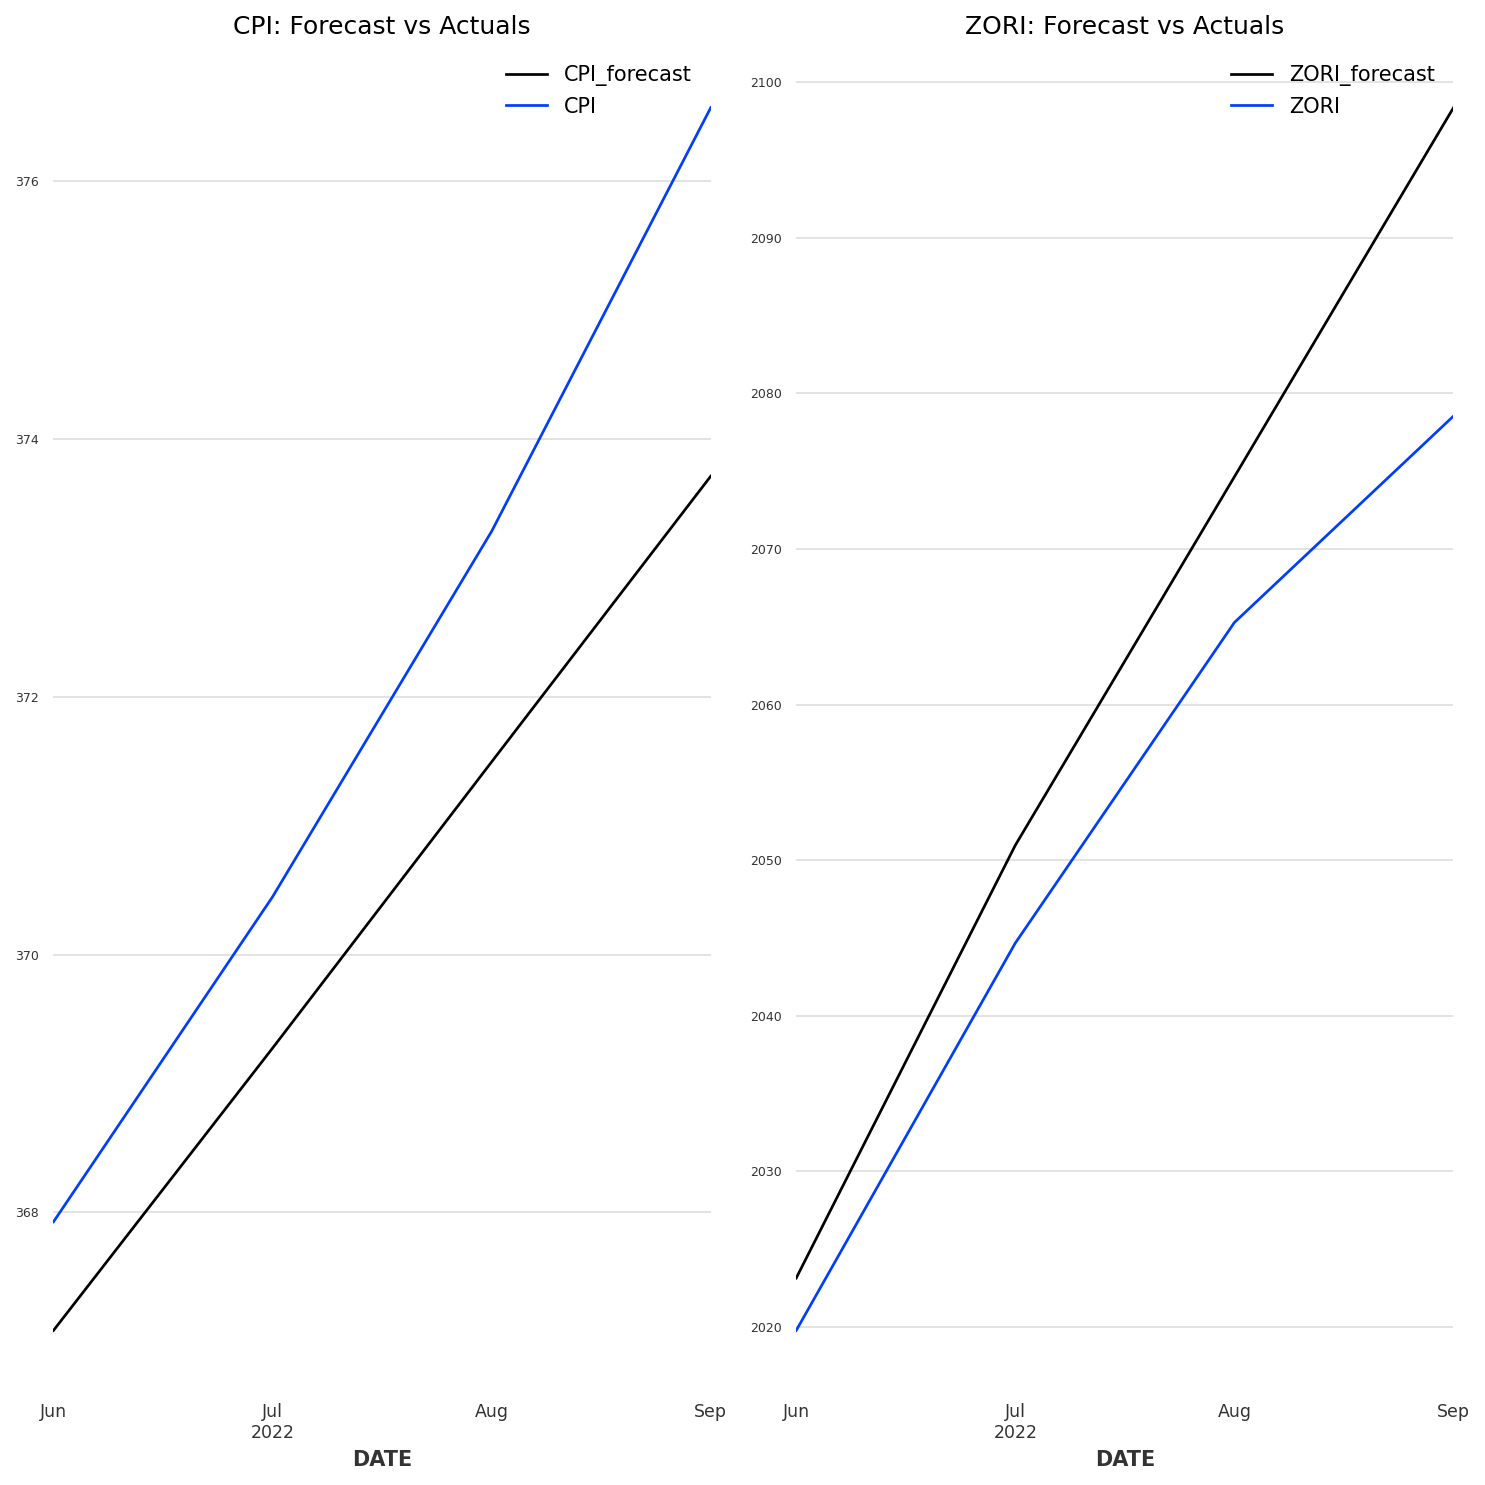

In [343]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

## Finding RMSE

In [344]:
from statsmodels.tsa.stattools import acf
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

print('Forecast Accuracy of: ZORI')
accuracy_prod = forecast_accuracy(df_results['ZORI_forecast'].values, df_test['ZORI'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Forecast Accuracy of: ZORI
mape   :  0.0047
me     :  9.7139
mae    :  9.7139
mpe    :  0.0047
rmse   :  11.5318
corr   :  0.995
minmax :  0.0047


C:\Users\am513\AppData\Local\Temp\ipykernel_25156\939094547.py:10: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)
C:\Users\am513\AppData\Local\Temp\ipykernel_25156\939094547.py:12: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  actual[:,None]]), axis=1)


## Congratulations!
You have finished!

Now let's try utilizing the ZORI to help predict CPI. Similar to regular regression tasks, we can use covariates like ZORI to help predict CPI changes.

We'll start by doing some data cleaning and conversion so we can do our modeling.

In [349]:
zillow_copy=zillow.copy()
zillow_copy["date_ms"]=zillow["DATE"].astype("datetime64[M]")
zillow_copy=zillow_copy.drop(["DATE","index"],axis=1)

In [351]:
zillow_copy.head()

,level_0,ZORI,date_ms
0,0,1370.301806,2015-03-01
1,1,1381.971304,2015-04-01
2,2,1392.389090,2015-05-01
3,3,1403.203509,2015-06-01
4,4,1408.901384,2015-07-01


Now let's merge all of our datasets together. This will allow us to more easily do our modeling.

In [352]:
comb_data=pd.merge(zillow_copy, usCPI, left_on="date_ms",right_on="DATE")

In [353]:
comb_data.head()

,level_0,ZORI,date_ms,CPI
0,1,1381.971304,2015-04-01,283.598
1,2,1392.389090,2015-05-01,284.245
2,3,1403.203509,2015-06-01,285.031
3,4,1408.901384,2015-07-01,286.090
4,5,1414.264526,2015-08-01,287.068


As a quick sanity check, we'll run a correlation to see if the ZORI index is related to the CPI.

In [356]:
comb_data.drop("level_0",axis=1).corr()

C:\Users\am513\AppData\Local\Temp\ipykernel_25156\4285307872.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  comb_data.drop("level_0",axis=1).corr()


,ZORI,CPI
ZORI,1.00000,0.94072
CPI,0.94072,1.00000


Based on the correlation of 94%, the ZORI index seems like a good candidate as a covariate for prediction.

We can also verify this visually.

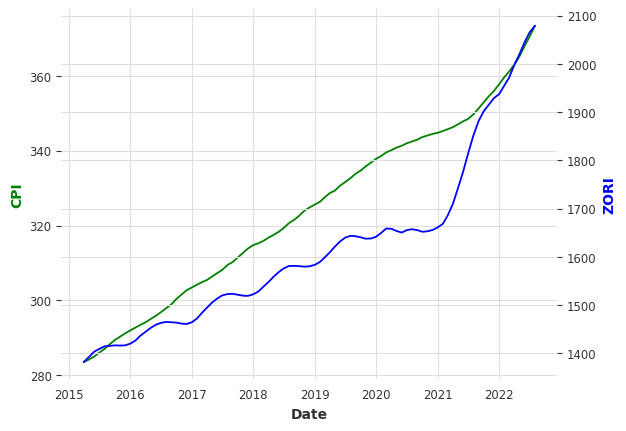

In [374]:
import numpy as np
import matplotlib.pyplot as plt
x = comb_data["date_ms"]
y1 = comb_data["CPI"]
y2 = comb_data["ZORI"]

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y1, 'g-')
ax2.plot(x, y2, 'b-')

ax1.set_xlabel("Date")
ax1.set_ylabel('CPI', color='g')
ax2.set_ylabel('ZORI', color='b')
plt.show()



Now let's get ready for our forecasting. We'll start by installing and loading in the `darts` package. The `darts` package allows for powerful forecasting in a similar format to `sklearn`'s `fit()` and `predict()` framework.

In [76]:
! pip install darts

In [357]:
import darts
from darts import TimeSeries
from darts.dataprocessing.transformers.scaler import Scaler
from darts.models.forecasting.nhits import NHiTSModel

The `darts` package requires that all data be entered into a `TimeSeries` datatype. Since we'll be using a neural network for forecasting, we will also be scaling the data so the neural network can better predict. 

In [361]:
zori_ts = TimeSeries.from_dataframe(comb_data, time_col="date_ms",value_cols="ZORI")
zori_scaler = Scaler()
zori_ts_scaled = zori_scaler.fit_transform(zori_ts) 

In [362]:
zori_ts_scaled

<TimeSeries (DataArray) (date_ms: 89, component: 1, sample: 1)>
array([[[0.        ]],

       [[0.01495573]],

       [[0.03048087]],

       [[0.03866072]],

       [[0.04636002]],

       [[0.04770229]],

       [[0.04928438]],

       [[0.04871635]],

       [[0.04925226]],

       [[0.05430049]],

...

       [[0.76592654]],

       [[0.78523344]],

       [[0.79723393]],

       [[0.82302831]],

       [[0.84597621]],

       [[0.88398257]],

       [[0.91559666]],

       [[0.95135753]],

       [[0.98094917]],

       [[1.        ]]])
Coordinates:
  * date_ms    (date_ms) datetime64[ns] 2015-04-01 2015-05-01 ... 2022-08-01
  * component  (component) object 'ZORI'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

We'll do the same for the CPI data.

In [363]:
cpi_ts = TimeSeries.from_dataframe(comb_data, time_col="date_ms",value_cols="CPI")
cpi_scaler = Scaler()
cpi_ts_scaled = cpi_scaler.fit_transform(cpi_ts)

For training and testing, we will split so our training set ends in 2021 and our test set will begin in 2022. 

In [232]:
zori_ts_train, zori_ts_val = zori_ts_scaled.split_after(pd.Timestamp("2021-12-01"))

In [233]:
cpi_ts_train, cpi_ts_val = cpi_ts_scaled.split_after(pd.Timestamp("2021-12-01"))

For our model, we'll be using a `NHiTS` or Neural Hierarchical interpolation for Time Series model for our forecasting. This cell might take a little while to run.

In [368]:
model = NHiTSModel(input_chunk_length=24, output_chunk_length=len(cpi_ts_val))
model.fit(series=cpi_ts_train, past_covariates=zori_ts_train, epochs=500)
prediction = cpi_scaler.inverse_transform(model.predict(n=len(cpi_ts_val), past_covariates=zori_ts_train, series=cpi_ts_train))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | stacks        | ModuleList       | 881 K 
---------------------------------------------------
857 K     Trainable params
24.6 K    Non-trainable params
881 K     Total params
7.054     Total estimated model params size (MB)


Epoch 499: 100%|██████████████████████████████████████| 2/2 [00:00<00:00, 13.60it/s, loss=6.63e-05, train_loss=6.63e-5]

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████████████████████████████████| 2/2 [00:00<00:00, 12.89it/s, loss=6.63e-05, train_loss=6.63e-5]


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 41.89it/s]


Now that we have our predictions, we can plot them against the actual values for the testing period. Since we used a scaler at the beginning, we will have to inverse it so we have the actual values.

Accuracy:  0.97


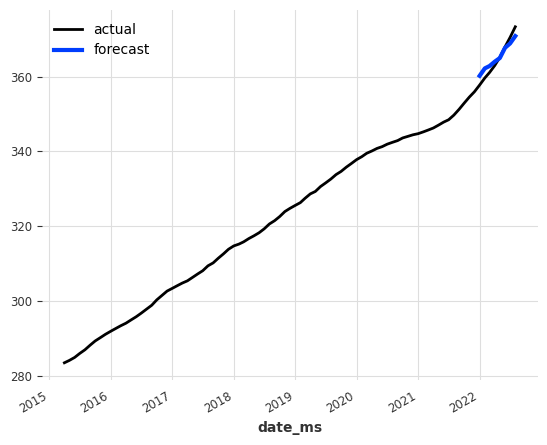

In [371]:
cpi_ts.plot(label = 'actual')
prediction.plot(label = 'forecast', lw = 3)
accuracy=(1-sum(abs(cpi_scaler.inverse_transform(cpi_ts_val).values()-prediction.values())/prediction.values()))[0]
print("Accuracy: ",np.round(accuracy,2))
plt.legend();